# Setup new detection with CNN

## Preparations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import glob
from shutil import copy2
import os

import pathlib as pl
from datetime import datetime
from datetime import timezone

import cv2

#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Sequential
from keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset
#TODO: implement new structure  data then classes, pos->arrow, neg->nothing

2024-11-04 01:24:23.187610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SIZE_FACTOR = 0.3
CRITICAL_DIST_FROM_OTHER_CENTER = 20
TARGET_SIZE = (24, 68)
AREA_BORDER = TARGET_SIZE[0] * TARGET_SIZE[1]
WIDTH_TO_HEIGHT = TARGET_SIZE[0] / TARGET_SIZE[1]
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

In [3]:
RED = (0, 0, 255)
BLUE = (255, 0, 0)
PURPLE = (255, 0, 255)

In [4]:
def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]    

In [5]:
def rotate_and_crop_min_rect(image, min_area_rect):
    factor = 1.3

    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    if width_to_height >= 1:
        angle = -1 * (90 - min_area_rect[2])
    else:
        angle = min_area_rect[2]    

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))
    size = (min_needed_height, min_needed_height)

    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    cropped = cv2.getRectSubPix(image, size, center)
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    return cropped_rotated

In [6]:
def check_contours_manually(cnts, frame, color):
    for num, contour in enumerate(cnts):
        con_frame = frame.copy()
        cv2.drawContours(con_frame, cnts, num, color, thickness=10)
        cv2.imshow('Frame',con_frame)
        key = cv2.waitKey(0) & 0xFF
        if key == ord('y'):
            return contour
        elif key == ord('q') or key == 27:
            return None
        elif key == ord('r'):
            return check_contours_manually(cnts, frame, color)
        
    return None

In [7]:
def filter_and_extract_img_from_cnt(gray_img, con):
    min_rect = cv2.minAreaRect(con)
    center, size, angle = min_rect
    area = size[0] * size[1]

    if area < AREA_BORDER:
        return None

    low_value = min(size[0], size[1])
    high_value = max(size[0], size[1])
    width_to_height = low_value / high_value

    if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
        cropped_img = rotate_and_crop_min_rect(gray_img, min_rect)
        small_img = cv2.resize(cropped_img, TARGET_SIZE)
        return small_img

    return None

In [8]:
def filter_and_extract_norm_img_from_cnt(gray_img, con):
    small_img = filter_and_extract_img_from_cnt(gray_img, con)
    if small_img is not None:
        small_img = small_img / 255
        return small_img

    return None

In [9]:
def extract_img_from_cnt(gray_img, cnt):
    min_rect = cv2.minAreaRect(cnt)
    cropped_img = rotate_and_crop_min_rect(gray_img, min_rect)
    small_img = cv2.resize(cropped_img, TARGET_SIZE)
    return small_img

In [10]:
def get_current_time_string():
    return datetime.now(timezone.utc).strftime('%Y-%m-%d_%H-%M-%S-%f')

In [11]:
video_path = '../../2023-09-01-163208.webm'

In [12]:
video_path = '../../2023-12-04-201531.webm'

In [13]:
video_path = '../../2024-10-24-213011.webm'

In [14]:
video_path = '../../2024-10-24-213212.webm'

## extract positive training data

In [15]:
from datetime import datetime
from datetime import timezone

import pdb

if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model_filename = 'arrow_detection.h5'
    if pl.Path(model_filename).exists():
        print('loaded model')
    else:
        print('model not yet created')

if 'model' in dir():
    model.trainable = False

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    cap.release()
    raise SystemExit()

frameRate = cap.get(5) #frame rate
abort = False
try:
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret == False:
            break
            
        # Display the resulting frame
        cv2.imshow('Frame', frame)
    
        key = cv2.waitKey(25) & 0xFF
    
        # Press Q on keyboard to  exit
        if key == ord('q') or abort:
            break
        elif frameId % np.floor(frameRate/2) == 0:
            centers = []

            gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            blurred = cv2.blur(gray_img, (3,3))
            
            sigma = 0.33
            v = np.median(blurred)
            
            #---- apply automatic Canny edge detection using the computed median----
            lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
            upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
            thresh_img = cv2.Canny(blurred, lower, upper)
            cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
            filtered_norm_imgs = [] # TODO: use np.ma next time
            filtered_cnts = []
            pos_filtered_to_pos_source = {}
            pos_filtered = 0
            for pos_source, con in enumerate(cnts):
                small_img = filter_and_extract_norm_img_from_cnt(blurred, con)
                if small_img is not None:
                    filtered_cnts.append(con)
                    filtered_norm_imgs.append(small_img)
                    pos_filtered_to_pos_source[pos_filtered] = pos_source
                    pos_filtered += 1
            
            filtered_norm_imgs = np.array(filtered_norm_imgs)
            if 'model' in dir():
                prediction = model.predict(filtered_norm_imgs).flatten()
            else:
                prediction = [False] * len(filtered_norm_imgs)

            positive_contours = []
            negative_contours = []

            for idx, value in enumerate(prediction):
                idx_ = pos_filtered_to_pos_source[idx]
                if value >= 0.5:
                    M = cv2.moments(cnts[idx_])
                    center_x = M['m10'] // M['m00']
                    center_y = M['m01'] // M['m00']
                    #TODO: filter based on centers
                    too_close_to_other_center = False
                    for x, y in centers:
                        if x-CRITICAL_DIST_FROM_OTHER_CENTER < center_x < x+CRITICAL_DIST_FROM_OTHER_CENTER:
                            if y-CRITICAL_DIST_FROM_OTHER_CENTER < center_y < y+CRITICAL_DIST_FROM_OTHER_CENTER:
                                too_close_to_other_center = True
                                print(f'{center_x} and {center_y} are too close to another center')
                                break

                    if not too_close_to_other_center:
                        centers.append((center_x, center_y))
                        positive_contours.append(cnts[idx_])
                else:
                    negative_contours.append(cnts[idx_])

            con_frame = frame.copy()
            
            if len(positive_contours):
                cv2.drawContours(con_frame, positive_contours, -1, BLUE, thickness=10)
            if len(negative_contours):
                cv2.drawContours(con_frame, negative_contours, -1, RED, thickness=10)
                
            if len(positive_contours) > 1:
                cv2.putText(con_frame, f'many good values found; len(positive_contours)={len(positive_contours)}', (10,460), cv2.FONT_HERSHEY_SIMPLEX, .5, RED)    
            elif len(positive_contours) == 1:
                cv2.putText(con_frame, f'one good values found; len(positive_contours)={len(positive_contours)}', (10,460), cv2.FONT_HERSHEY_SIMPLEX, .5, BLUE)    
            else:
                cv2.putText(con_frame, f'no good value found; len(filtered_norm_imgs)={len(filtered_norm_imgs)}', (10,460), cv2.FONT_HERSHEY_SIMPLEX, .5, RED)
                
            cv2.imshow('Frame',con_frame)
            key = cv2.waitKey(0) & 0xFF
            
            if key == ord('n'):
                contour  = check_contours_manually(filtered_cnts, frame, PURPLE)
                if contour is not None:
                    small_img = extract_img_from_cnt(blurred, contour)
                    timestring = datetime.now(timezone.utc).strftime('%Y-%m-%d_%H-%M-%S-%f')
                    retval = cv2.imwrite(f'../original-positives/img_{timestring}.jpg', small_img)
                    if not retval:
                        raise ValueError(f'retval:{retval}')
      
            elif key == ord('y'):
                if len(positive_contours) == 1:
                    small_img = extract_img_from_cnt(blurred, positive_contours[0])
                    timestring = get_current_time_string()
                    retval = cv2.imwrite(f'../original-positives/original-positives/img_{timestring}.jpg', small_img)
                    if not retval:
                        raise ValueError(f'retval:{retval}')
                
                else:
                    print('too many values -> no save')
                
            elif key == ord('q') or key == 27:
                abort = True
                break

except Exception as e:
    print(e)
    
cap.release()
cv2.destroyAllWindows()

print('done')

load model...
loaded model
done


In [ ]:
cap.release()
cv2.destroyAllWindows()

## Create multiple images of pos images

In [13]:
# deprecated
generated_versions = 70

In [14]:
# deprecated
data_gen = ImageDataGenerator(rotation_range=2, rescale=1. / 255, shear_range=0.05,
                              zoom_range=0.01, horizontal_flip=False)

NameError: name 'ImageDataGenerator' is not defined

In [14]:
# deprecated
path = pl.Path('../original-positives/')

if not path.is_dir():
    raise IOError('path not valid')
    
for num, image_name in enumerate(path.iterdir()):
    # Create image to tensor
    img = load_img(str(image_name), grayscale=False)
    arr = img_to_array(img)
    tensor_image = arr.reshape((1, ) + arr.shape)

    for nbr_of_created_imgs, _ in enumerate(data_gen.flow(
        x=tensor_image,
        batch_size=1,
        save_to_dir='../pos',
        save_prefix='generated',
        save_format='jpg')
    ):
        if nbr_of_created_imgs >= generated_versions:
            break
    

In [11]:
path = pl.Path('../original-positives/')

In [12]:
org_ds = image_dataset_from_directory(
  path,
  image_size=(TARGET_SIZE[1], TARGET_SIZE[0]),
  batch_size=1_000)

Found 325 files belonging to 1 classes.


In [24]:
aug_net = Sequential([
    layers.RandomRotation(0.025),
    layers.RandomTranslation(0.1,0.04, fill_value=255),
])

(325, 68, 24, 3)


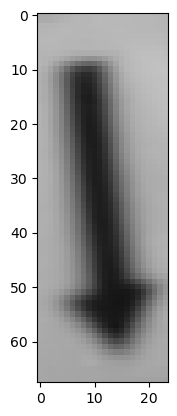

(325, 68, 24, 3)


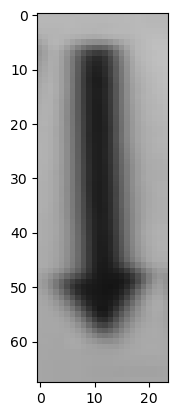

(325, 68, 24, 3)


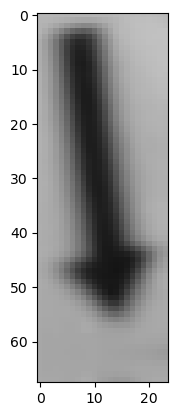

(325, 68, 24, 3)


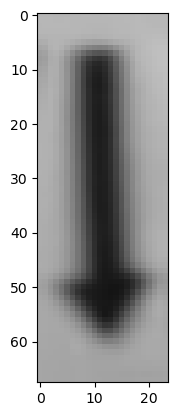

(325, 68, 24, 3)


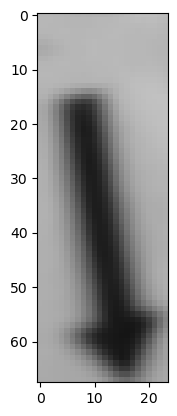

(325, 68, 24, 3)


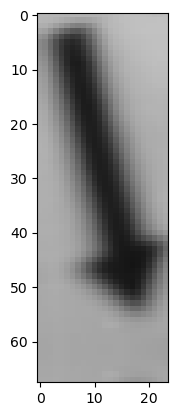

(325, 68, 24, 3)


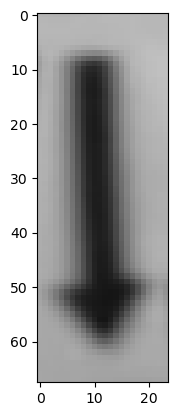

(325, 68, 24, 3)


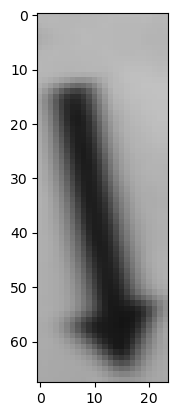

(325, 68, 24, 3)


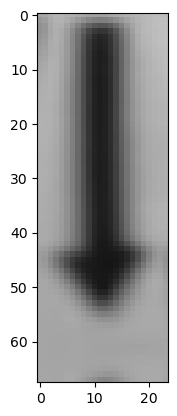

(325, 68, 24, 3)


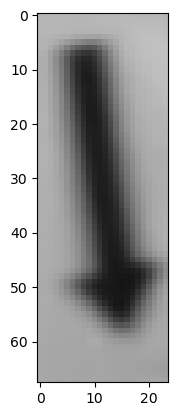

(325, 68, 24, 3)


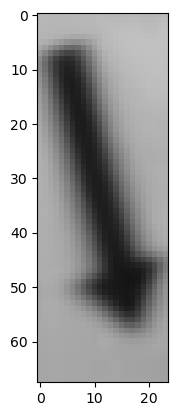

(325, 68, 24, 3)


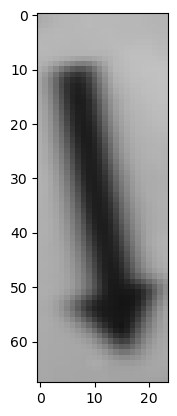

(325, 68, 24, 3)


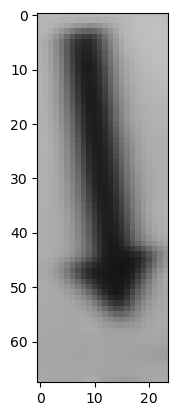

(325, 68, 24, 3)


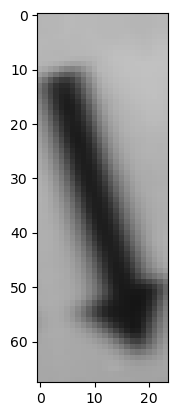

(325, 68, 24, 3)


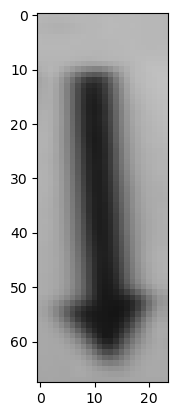

(325, 68, 24, 3)


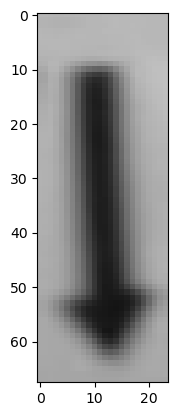

(325, 68, 24, 3)


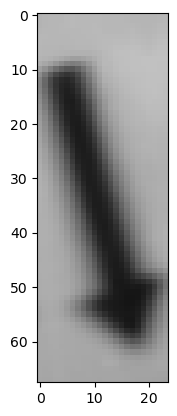

(325, 68, 24, 3)


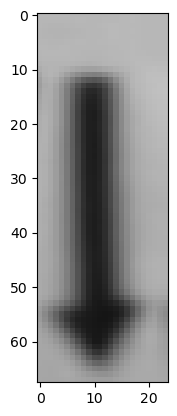

(325, 68, 24, 3)


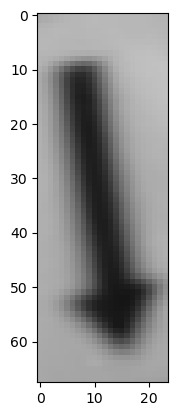

(325, 68, 24, 3)


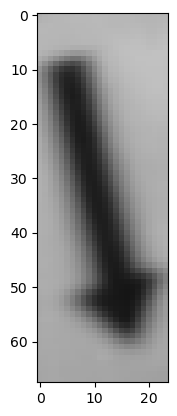

(325, 68, 24, 3)


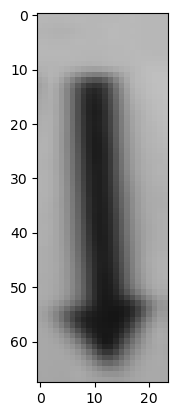

(325, 68, 24, 3)


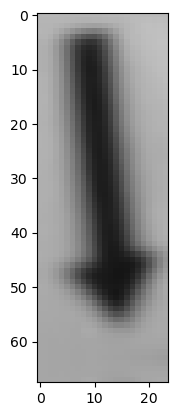

(325, 68, 24, 3)


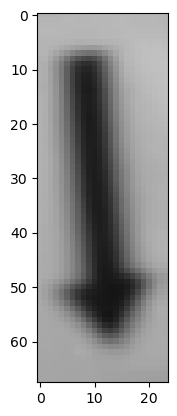

(325, 68, 24, 3)


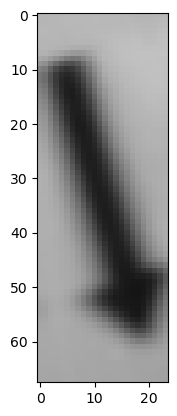

(325, 68, 24, 3)


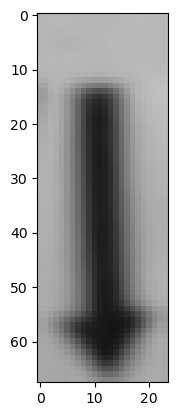

(325, 68, 24, 3)


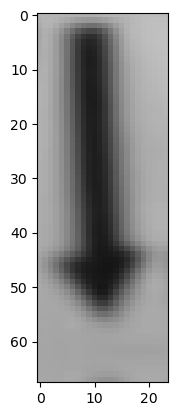

(325, 68, 24, 3)


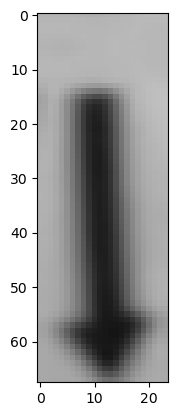

(325, 68, 24, 3)


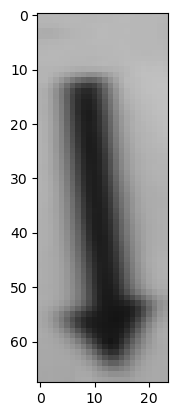

(325, 68, 24, 3)


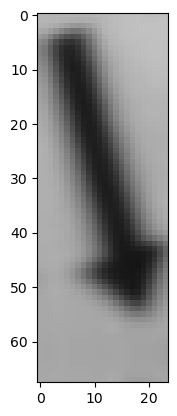

(325, 68, 24, 3)


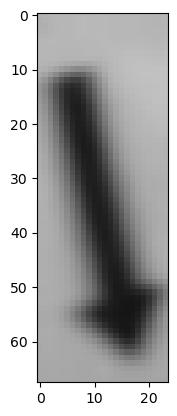

In [28]:
for all_images, label in org_ds:
    for i in range(30):
        aug_imgs = aug_net(all_images).numpy()
        print(aug_imgs.shape)
        tmp_img = aug_imgs[0].astype(int)
        plt.imshow(tmp_img)
        plt.show()
        # TODO: save, clean up
    break # avoid error message

In [27]:
10_000 / 325

30.76923076923077

## Extract negative training data

In [15]:
neg_image_path = '../../raw-images'

In [16]:
path = pl.Path(neg_image_path)

In [19]:
for num, image_name in enumerate(path.iterdir()):
    big_neg_image = cv2.imread(str(image_name))
    if big_neg_image is None:
        print(f'could not load image {image_name}')
        break
    
    blurred = cv2.blur(big_neg_image, (3,3))
    gray_img = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    #thresh_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
    #thresh_img = cv2.Canny(gray_img, 100, 255)
    
    sigma = 0.33
    v = np.median(gray_img)

    #---- apply automatic Canny edge detection using the computed median----
    lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
    upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
    thresh_img = cv2.Canny(gray_img, lower, upper)
    #plt.imshow(thresh_img)
    cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for con in cnts:
        small_img = filter_and_extract_img_from_cnt(gray_img, con)
        if small_img is not None:
            timestring = get_current_time_string()
            retval = cv2.imwrite(f'../../unused-neg/img_{timestring}.jpg', small_img)
            if not retval:
                raise ValueError(f'retval saving small img:{retval}')
                
    if num % 10 == 0:
        print(f'at least {num} raw images finished', end='\r')

## Move random negative files to neg

In [20]:
used_neg_filenames = random.sample(glob.glob('../../unused-neg/*.jpg'), k=10_000)
for filename in used_neg_filenames:
    copy2(filename, f'../dataset/anything/{os.path.basename(filename)}')